### Mkhanyisi Gamedze
#### COSI 165B Deep Learning
#### Term Project Analysis - Google Cloud
#### 10 May 2022



DataSet link: https://competitions.codalab.org/competitions/4081#participate-get-data or https://chalearnlap.cvc.uab.cat/dataset/17/description/

In [82]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import ndimage, misc
import imageio
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

### Load Data

Build labels Dataframe

<b>Train Labels</b>

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
r="/content/drive/MyDrive/COSI 165B Deep Learning/Term project"
os.chdir(r)
print(os.getcwd())

/content/drive/MyDrive/COSI 165B Deep Learning/Term project


### Load saved data

In [85]:
os.chdir(r)
print(os.getcwd())
os.listdir()

/content/drive/MyDrive/COSI 165B Deep Learning/Term project


['dataset', 'Numpy Clean Dataset']

In [86]:
os.chdir('./Numpy Clean Dataset')

In [87]:
fulldataX=np.load('smallerdataX.npy')

fulldataX.shape

(2254, 256, 256, 3)

In [88]:
fulldataY=np.load('reencoded_smallerdataY.npy')
fulldataY.shape

(2254, 1)

<b>Test Transform</b>

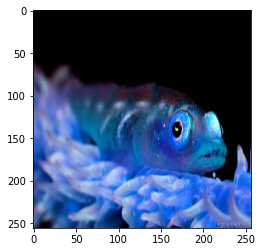

In [89]:
plt.imshow(fulldataX[1])
plt.show()

In [90]:
fulldataY.shape

(2254, 1)

#### To Tensor

In [91]:
tensordataX = torch.FloatTensor(fulldataX)

tensordataY = torch.FloatTensor(fulldataY.astype(int))


tensordataX.shape, tensordataY.shape

(torch.Size([2254, 256, 256, 3]), torch.Size([2254, 1]))

<b>Permute Images so input channel is color for convolution</b>

In [92]:
tensordataX=tensordataX.permute(0,3,1,2)
tensordataX.shape

torch.Size([2254, 3, 256, 256])

### Train-Test split (80 : 20)

In [122]:
p=int(0.8*(tensordataX.shape[0]))

trainX=tensordataX[:p]
testX=tensordataX[p:]
trainY=tensordataY[:p]
testY=tensordataY[p:]

trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([1803, 3, 256, 256]),
 torch.Size([1803, 1]),
 torch.Size([451, 3, 256, 256]),
 torch.Size([451, 1]))

### Vanilla CNN model

In [214]:
# CNN model
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        # define convolution layers
        """
        self.conv1 = nn.Conv2d(3, 96, kernel_size=(7,7), stride=2)
        self.conv2 = nn.Conv2d(96, 512, kernel_size=(3,3), stride=1)
        """
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5), stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5), stride=1)
        
        
        # figure out output conv flat length
        x = torch.randn(1,3,256,256)
        self._to_linear = None
        self.convs(x)
        
        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 500)
        self.fc2 = nn.Linear(500,250)
        self.fc3 = nn.Linear(250, 11)
        self.softmax = nn.Softmax(dim=1)

        
    def convs(self, x):
        # max pooling over 2x2 both Conv layers
        x=self.conv1(x)
        x=F.relu(x)
        x =F.max_pool2d(x, (2, 2))
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        
        #print(x.shape)
        # first pass, figure flat length
        if self._to_linear is None:
            print("x[0] : ",x[0].shape)
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x) # first two convolutional layers
        x = x.reshape(-1, self._to_linear) # flatten x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.sigmoid(self.fc3(x)) # Sigmoidal activation for output layer since two class problem
        x=F.log_softmax(self.fc3(x), dim=1)
        
        #x=self.softmax(self.fc3(x))
        #print("x:",x.shape)
        #print("x:",x)
        return x

In [215]:
vanillaCNN=Net()

x[0] :  torch.Size([16, 61, 61])


In [216]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device "%s" for training' % dev)
vanillaCNN.to(dev)

Using device "cuda" for training


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)

In [217]:
#transform = torchvision.transforms.ToTensor()
img=trainX[:19].cuda()
print("image shape: ",img.shape)
print("reshaped img: ",img.view(-1,3,256,256).shape)

v=torch.randn(1,3,256,256).cuda()
print("v shape: ",v.shape)
r=vanillaCNN.forward(v)
simg=torch.squeeze(img.view(-1,3,256,256))
print("squezzed img: ",simg.shape)


im= torch.rand(10, 3, 256,256).cuda()
print("rand tensor shape: ",im.shape)
c=vanillaCNN.forward(im)

print("output: ",r)
print("rand img output: ",c.shape)

image shape:  torch.Size([19, 3, 256, 256])
reshaped img:  torch.Size([19, 3, 256, 256])
v shape:  torch.Size([1, 3, 256, 256])
squezzed img:  torch.Size([19, 3, 256, 256])
rand tensor shape:  torch.Size([10, 3, 256, 256])
output:  tensor([[-2.3014, -2.4221, -2.4900, -2.3688, -2.3860, -2.4351, -2.3457, -2.4537,
         -2.4456, -2.3443, -2.4000]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
rand img output:  torch.Size([10, 11])


In [218]:
b=vanillaCNN.forward(img)
print("batch result: ",b.shape)

batch result:  torch.Size([19, 11])


In [219]:
print("CNN Model:\n",vanillaCNN)

CNN Model:
 Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)


#### Train model

In [220]:
EPOCHS = 40
BATCH_SIZE = 100

In [221]:
min_loss = np.Inf #lowest loss will be the loaded model

loss_function = nn.CrossEntropyLoss().to(dev) 

optimizer = optim.Adam(vanillaCNN.parameters(),lr=0.00001)

epoch_num=[]
loss_arr=[]

enum=0
for epoch in range(EPOCHS):
    train_loss = 0
    vanillaCNN.train()
    for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
        #print(f"{i}:{i+BATCH_SIZE}")
        
        batch_X = trainX[i:i+BATCH_SIZE].to(dev)
        batch_y = trainY[i:i+BATCH_SIZE].to(dev)
        batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)
        
        vanillaCNN.zero_grad()
        #print("batch shape: ",batch_X.shape)
        batch_X=batch_X.cuda()
        batch_y=batch_y.cuda()

        outputs = vanillaCNN(batch_X)
        outputs.to(dev)
        #print("result shape: ",outputs.shape,batch_y.shape)
        
        #print(outputs.dtype)
        #print(batch_y.dtype)
        #print(outputs.shape," <=> ",batch_y.shape)
        
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    #update weights
        
        #print(loss.item())
        #print(loss.item()," - ",len(train_x))
        train_loss += loss.item()/len(trainX)
    #print("train loss: ",train_loss)
    if epoch % 5 == 0:
        print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
            epoch,
            train_loss,
            min_loss
        )) 
    if train_loss < min_loss:   
        min_loss = train_loss
    print(train_loss)
    epoch_num.append(enum)
    loss_arr.append(train_loss)
    enum+=1

100%|██████████| 19/19 [00:02<00:00,  8.79it/s]


Epoch: 0, Train Loss: 0.1531, Current Min Loss: inf

0.15310643734752002


100%|██████████| 19/19 [00:02<00:00,  9.21it/s]


0.05557212840168595


100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


0.05647302123486037


100%|██████████| 19/19 [00:02<00:00,  9.16it/s]


0.046029018615261416


100%|██████████| 19/19 [00:02<00:00,  9.14it/s]


0.037532489381098315


100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


Epoch: 5, Train Loss: 0.0374, Current Min Loss: 0.0375

0.03737207419066977


100%|██████████| 19/19 [00:02<00:00,  9.12it/s]


0.035582625545267914


100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


0.033004763337287114


100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


0.031848970298560805


100%|██████████| 19/19 [00:02<00:00,  9.00it/s]


0.031053754417881725


100%|██████████| 19/19 [00:02<00:00,  9.00it/s]


Epoch: 10, Train Loss: 0.0299, Current Min Loss: 0.0311

0.029912130738785715


100%|██████████| 19/19 [00:02<00:00,  9.00it/s]


0.02902105931632729


100%|██████████| 19/19 [00:02<00:00,  8.95it/s]


0.028613738025550506


100%|██████████| 19/19 [00:02<00:00,  8.91it/s]


0.028053064752603593


100%|██████████| 19/19 [00:02<00:00,  8.94it/s]


0.027092027229464063


100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


Epoch: 15, Train Loss: 0.0274, Current Min Loss: 0.0271

0.027370407995553528


100%|██████████| 19/19 [00:02<00:00,  8.87it/s]


0.026455632594315395


100%|██████████| 19/19 [00:02<00:00,  8.88it/s]


0.025267514407932262


100%|██████████| 19/19 [00:02<00:00,  8.87it/s]


0.025012443041510537


100%|██████████| 19/19 [00:02<00:00,  8.88it/s]


0.024435587863722446


100%|██████████| 19/19 [00:02<00:00,  8.88it/s]


Epoch: 20, Train Loss: 0.0239, Current Min Loss: 0.0244

0.023886436531428686


100%|██████████| 19/19 [00:02<00:00,  8.89it/s]


0.02327601768229316


100%|██████████| 19/19 [00:02<00:00,  8.91it/s]


0.022902505465070867


100%|██████████| 19/19 [00:02<00:00,  8.91it/s]


0.022315639211149


100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


0.021952053022695393


100%|██████████| 19/19 [00:02<00:00,  8.91it/s]


Epoch: 25, Train Loss: 0.0214, Current Min Loss: 0.0220

0.021405599610513273


100%|██████████| 19/19 [00:02<00:00,  8.01it/s]


0.021091092805596637


100%|██████████| 19/19 [00:02<00:00,  8.98it/s]


0.020491887146376665


100%|██████████| 19/19 [00:02<00:00,  9.00it/s]


0.02143340915672923


100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


0.020090714444138246


100%|██████████| 19/19 [00:02<00:00,  9.04it/s]


Epoch: 30, Train Loss: 0.0193, Current Min Loss: 0.0201

0.01932665420550475


100%|██████████| 19/19 [00:02<00:00,  9.03it/s]


0.01908842855222478


100%|██████████| 19/19 [00:02<00:00,  9.05it/s]


0.018182107931828406


100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


0.018095842607554896


100%|██████████| 19/19 [00:02<00:00,  9.08it/s]


0.01767461952927439


100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


Epoch: 35, Train Loss: 0.0173, Current Min Loss: 0.0177

0.017336246591108877


100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


0.01694891896435637


100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


0.016567597933283


100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


0.016365194130178562


100%|██████████| 19/19 [00:02<00:00,  9.06it/s]

0.0159052337188722


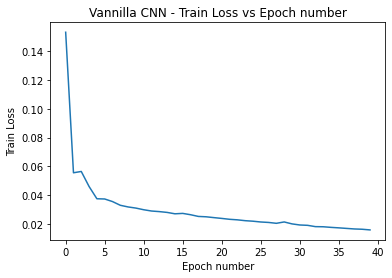

In [222]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

#### Test

In [223]:
#def test(model,test_x,test_y):
def model_test(test_x,test_y, model, epoch_num=EPOCHS):
    model.train(False)
    correct = 0
    total = 0

    #print(test_y)
    with torch.no_grad():
        for i in tqdm(range(len(test_x))):
            real_class = test_y[i].to(dev)
            images=test_x[i].view(-1,3,64,64).to(dev)
            net_out = model(images) # returns a list, 

            predicted_class = torch.argmax(net_out,dim=1)
            #print(net_out," =>",predicted_class," : ",real_class)
            if predicted_class == real_class:
                correct += 1
                #print(net_out," =>",predicted_class," : ",real_class)
            total += 1
    print("Accuracy: ", round((correct/total)*100, 3)," % ")

In [224]:
vanillaCNN.train(False)
correct = 0
total = 0

#print(test_y)

with torch.no_grad():
    for i in tqdm(range(len(testX))):
        real_class = testY[i].to(dev)
        images=testX[i].view(-1,3,256,256).to(dev)
        net_out = vanillaCNN(images) # returns a list, 
        
        predicted_class = torch.argmax(net_out,dim=1)
        #print(net_out," =>",predicted_class," : ",real_class)
        #print(predicted_class.shape," : ",real_class.shape)
        if predicted_class == real_class:
            correct += 1
            #print(net_out," =>",predicted_class," : ",real_class)
        total += 1
print("Initial Model Accuracy: ", round((correct/total)*100, 3)," % ")

100%|██████████| 451/451 [00:00<00:00, 722.69it/s]

Initial Model Accuracy:  37.029  % 


### Resources

- https://competitions.codalab.org/competitions/4081#participate-get-data
- 


- https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html

##### 